In [2]:
%reload_ext autoreload
%autoreload 2

from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
import h5py
import numpy as np
import time
import xarray as xr
from itertools import groupby
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import plotly.graph_objects as go

from karabo_data import open_run, DataCollection
from calibration import (
    dark_offset, module_roi_intensity, parse_ids, find_proposal, SimpleImageViewer)

In [3]:
# Config parameters

proposal = 900089
dark_run_nr = 51
dark_data_file = "/gpfs/exfel/data/scratch/kamile/lpd_timing_scan/lpd_low.h5"

timing_run_nr = 58

modules_roi = [32, 64, 0, 128]

modules = "0:16" # [0, 1, 2, ..., 15] # "Can also gives as comma separated : '1, 2, 14'"

pulse_ids_with_xray = "1:20:2"

# Delay motor device id and property
delay_src = "FXE_RR_SYS/TSYS/UTC-1-S3"
delay_prop = "backTrg3.delay.value"

# List of modules
module_numbers = parse_ids(modules)
module_numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [11]:
find_proposal(proposal, dark_run_nr)

'/gpfs/exfel/exp/FXE/201931/p900089/raw/r0051'

# Evaluate dark  for all modules in parallel and store in file


In [5]:
# Store dark data in dark_data dictionary
# dark_data = {modno:data}

dark_data = {}

_dark_eval = partial(dark_offset, 
                     proposal,
                     dark_run_nr,
                     pulse_ids=":",
                     dettype='LPD')

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data[modno] = ret
        
print(f"Time to evaluate dark offset: {time.perf_counter() - t0}")  

Time to evaluate dark offset: 198.95823323633522


<IPython.core.display.Javascript object>


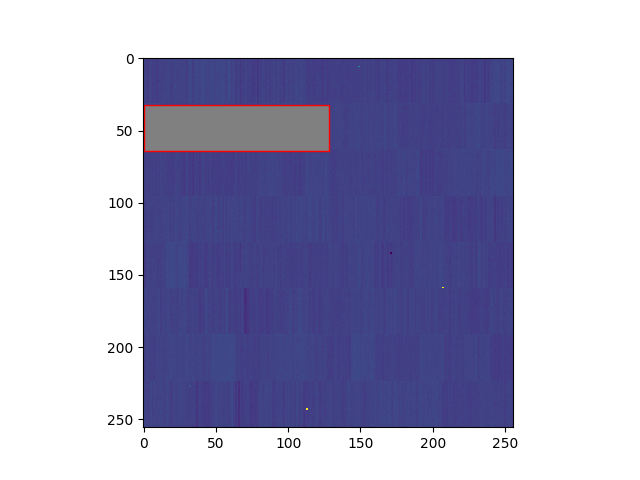

In [6]:
%matplotlib notebook

mod_to_view = 15
mem_cell_to_view = 2

fig, ax = plt.subplots(1,1)

x, y = modules_roi[2], modules_roi[0]
dx, dy = modules_roi[3] - modules_roi[2], modules_roi[1] - modules_roi[0]

rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='gray')

ax.add_patch(rect)

ax.imshow(dark_data[mod_to_view][mem_cell_to_view])

# Write dark data to file

In [7]:
with h5py.File(dark_data_file, "w") as f:
    g = f.create_group(f"entry_1/instrument")
    for modno, data in dark_data.items():
        if data is not None:
            h = g.create_group(f"module_{modno}")
            h.create_dataset('data', data=data)

# Browse thorugh dark subtracted images

In [ ]:
config = dict(
    run_folder=find_proposal(proposal, timing_run_nr),
    dark_data=dark_data_file
)

w = SimpleImageViewer("LPD", config)
w.control_panel()

# Evaluate ROI intensity for timing scan

        def module_roi_intensity(module_number, proposal, run, *,
                                 pulse_ids=None, rois=None,
                                 dettype='AGIPD', dark_run=None,
                                 use_xgm=None):
                    """ Process Dark data

                    Parameters
                    ----------
                    module_number: str, int
                        Channel number between 0, 15
                    proposal: str, int
                        A proposal number, such as 2012, '2012', 'p002012', or a path such as
                        '/gpfs/exfel/exp/SPB/201701/p002012'.
                    run: str, int
                        A run number such as 243, '243' or 'r0243'.
                    pulse_ids: str
                        For eg. ":" to select all pulses in a train
                                "start:stop:step" to select indices with certain step size
                                "1,2,3" comma separated pulse index to select specific pulses
                                "1,2,3, 5:10" mix of above two
                        Default: all pulses ":"
                    rois: list
                        [x0, x1, y0, y1]
                    dettype: str
                        "AGIPD", "LPD"
                    dark_run: (numpy.ndarray) or dict optional
                        dark_data shape (n_pulses, slow_scan, fast_scan)
                        dark_run[module_number] of shape (n_pulses, slow_scan, fast_scan)
                        Default: None,
                        If provided dark data will be subtracted from images
                    use_xgm: str
                        XGM source name to be used to normalize data.
                        For eg: "SPB_XTD9_XGM/DOOCS/MAIN:output"

                    Return
                    ------
                    out: xarray
                        The first axis of the returned data will be labelled with the trainId
                        Shape of numpy array: (n_trains, n_pulses)
                    """

### Read dark data from files and store in dictionary dark_run

In [8]:
dark_run = {}

import re
def iterate(name, node):
    if isinstance(node, h5py.Dataset):
        m = re.search("(.+)module_(.+)/data", name)
        if m is not None:
            dark_run[m.group(2)] = node[:]

with h5py.File(dark_data_file, 'r') as f:
    f.visititems(iterate)

dark_run.keys()

dict_keys(['1', '11', '12', '13', '14', '15', '2', '3', '4', '6', '7', '8', '9'])

### Evaluate  ROI intensities (xarrays)

In [9]:
# Store roi intensities in roi_intensities dictionary

roi_intensities = {}

_roi_intensity_eval = partial(module_roi_intensity, 
                              proposal=proposal,
                              run=timing_run_nr,
                              pulse_ids=pulse_ids_with_xray,
                              rois=modules_roi,
                              dettype='LPD',)

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(dark_run.keys())) as executor:
    for modno, ret in zip(
        dark_run.keys(), executor.map(
            _roi_intensity_eval, dark_run.keys())):
        roi_intensities[modno] = ret
        
print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

Time to evaluate roi intensities: 744.0321147432551


# Get delay data

In [10]:
run = open_run(proposal, timing_run_nr) # proposal, run
# get delay data: xarray
delay_data = run.get_array(delay_src, delay_prop)
delay_data = delay_data.expand_dims('dim_1', axis=1)

delay_data

<xarray.DataArray (trainId: 4869, dim_1: 1)>
array([[6381521],
       [6381521],
       [6381521],
       ...,
       [6381521],
       [6381521],
       [6381521]], dtype=int32)
Coordinates:
  * trainId  (trainId) uint64 589053244 589053245 ... 589058111 589058112
Dimensions without coordinates: dim_1

# Plot delay data and ROI intensities

In [13]:
for modno in sorted(dark_run.keys(), key=lambda x: int(x)):
    if roi_intensities[modno] is not None:
        # Align delay and ROI intensities along the trainIds
        roi_int, delay = xr.align(roi_intensities[modno], delay_data)
        # Evaluate MEAN and STD for a given delay
        data = []
        for pulse in range(roi_intensities[modno].shape[-1]):
            s = list(zip(delay[:, 0].values, roi_int[:, pulse].values))
            roi_int_avg = []
            roi_int_std = []
            dl = []
            for key, group in groupby(sorted(s), lambda x: x[0]):
                x, y = zip(*group)
                avg, std = np.mean(np.array(y)), np.std(np.array(y))
                roi_int_avg.append(avg)
                roi_int_std.append(std)
                dl.append(x[0])        

            data.append(go.Scatter(
                x=dl, 
                y=roi_int_avg, 
                xaxis_title="Delay",
                yaxis_title="ROI intensities",
                error_y=dict(
                    type='data',
                    array=roi_int_std,
                    visible=True),
                mode='lines+markers', 
                name=f"Pulse index: {pulse}"))

        fig = go.Figure(data=data, 
                        layout=go.Layout(
                        title=go.layout.Title(text=f"Module number {modno}")))
        fig.show()